In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow 
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25)

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)

In [8]:
def RNN_model():
    inputs = Input(name='inputs',shape=(max_len))
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [9]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [10]:
data=df.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

In [11]:
data["Message Length"]=data["Message"].apply(len)

In [12]:
data.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


In [13]:
data["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

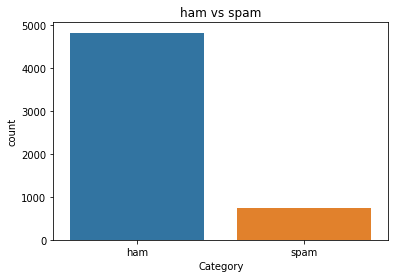

In [14]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()


In [15]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


In [16]:
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])
df=data.loc[undersampled_indices]
df=df.sample(frac=1)

df=df.reset_index()
df=df.drop(
    columns=["index"],
)

In [17]:
df.shape

(1494, 3)

In [18]:
df["Category"].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

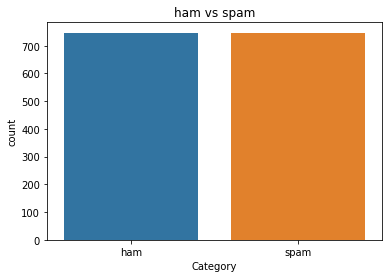

In [19]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [20]:
df.head()

,Category,Message,Message Length
0,ham,Not yet. Just i'd like to keep in touch and it...,137
1,ham,Kent vale lor... ÌÏ wait 4 me there ar?,39
2,spam,URGENT! We are trying to contact U. Todays dra...,160
3,ham,Now only i reached home. . . I am very tired n...,71
4,spam,Guess who am I?This is the first time I create...,152


In [35]:
df["Label"]=df["Category"].map({"ham":0,"spam":1})

In [22]:
df.head()

,Category,Message,Message Length,Label
0,ham,Not yet. Just i'd like to keep in touch and it...,137,0
1,ham,Kent vale lor... ÌÏ wait 4 me there ar?,39,0
2,spam,URGENT! We are trying to contact U. Todays dra...,160,1
3,ham,Now only i reached home. . . I am very tired n...,71,0
4,spam,Guess who am I?This is the first time I create...,152,1


In [23]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

In [24]:
corpus=[]
for message in df["Message"]:
    message=re.sub("[^a-zA-Z]"," ",message)
    message=message.lower()
    message=message.split()

In [25]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000
oneHot_doc=[one_hot(words,n=vocab_size) for words in corpus]

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [36]:
extract_features=pd.DataFrame(data=embedded_doc)
target=df["Label"]

In [28]:
df_final=pd.concat([extract_features,target],axis=1)

In [29]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [30]:
from sklearn.model_selection import train_test_split

In [37]:
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=72,test_size=0.25)

In [32]:
def RNN_model():
    inputs = Input(name='inputs',shape=(max_len))
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [40]:
model = RNN_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [34]:
# model.fit(X_trainval)

# Assignment 4 completed by Mohnish S (2019504551).